# Stock Market Prediction Univariate Recurrent Neural Networks

## Veri Çekme

In [1]:
!pip install yfinance

In [12]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import seaborn as sns

In [8]:
stockname = "Amazon"
symbol = "AMZN"
start_date = "2021-01-01"
end_date = "2022-10-15"
today = date.today()

In [9]:
import yfinance as yf 
df = yf.download(start=start_date,end =end_date,tickers =symbol, interval = "1h")

[*********************100%***********************]  1 of 1 completed


In [10]:
print(df.shape)
df.head(5)

(3148, 6)


,Open,High,Low,Close,Adj Close,Volume
2021-01-04 09:30:00-05:00,163.551559,163.558746,160.850006,161.753998,161.753998,817344
2021-01-04 10:30:00-05:00,161.800003,161.966507,159.399994,159.761993,159.761993,614296
2021-01-04 11:30:00-05:00,159.704254,159.774506,157.250000,158.030746,158.030746,809036
2021-01-04 12:30:00-05:00,157.992004,159.093994,157.201004,159.026505,159.026505,559356
2021-01-04 13:30:00-05:00,159.039459,159.520996,158.750000,159.024994,159.024994,362154


## Veri Görselleştirme

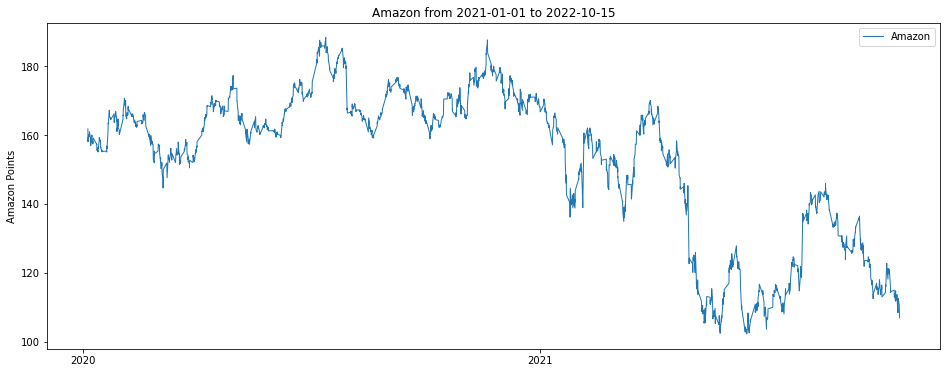

In [14]:
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ start_date + ' to ' + end_date)
sns.lineplot(data=df['Close'], label=stockname, linewidth=1.0)
plt.ylabel('Amazon Points')
plt.show()

## Veri Normalizasyonu(Ölçeklendirme)

In [15]:
train_df = df.filter(['Close'])
data_unscaled = train_df.values

In [16]:
train_data_length = math.ceil(len(data_unscaled) * 0.8)

In [17]:
train_data_length

2519

In [18]:
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

In [19]:
np_data

array([[0.6914207 ],
       [0.66827764],
       [0.64816405],
       ...,
       [0.06028572],
       [0.05447673],
       [0.05412821]])

## Girdiyi Düzenleme

Eğitime başlamadan veri setimizi train ve test olarak ayırmamız gerekiyor.Bu sayede test kısmı ile veriyi test edeceğiz.
Daha sonra ise son 1 haftanın 1'er saatlik verisine göre (yani ortalama 50 veri) bir sonraki saati tahmin etmeye çalışacağız.

In [20]:
index_Close = train_df.columns.get_loc("Close")
print(index_Close)

0


In [21]:
train_data_len = math.ceil(np_data.shape[0] * 0.8)

In [39]:
train_data_len

2519

In [23]:
sequence_length = 50
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

In [35]:
train_data[:10],test_data[:10]

(array([[0.6914207 ],
        [0.66827764],
        [0.64816405],
        [0.65973274],
        [0.65971519],
        [0.65738578],
        [0.66328766],
        [0.67249504],
        [0.66755736],
        [0.66562877]]),
 array([[0.12494555],
        [0.12696704],
        [0.12699026],
        [0.12820566],
        [0.14189042],
        [0.15019714],
        [0.17092074],
        [0.17622263],
        [0.19760436],
        [0.20076449]]))

In [37]:
def partition_dataset(sequence_length, train_df):
    x, y = [], []
    data_len = train_df.shape[0]
    for i in range(sequence_length, data_len):
        x.append(train_df[i-sequence_length:i,:]) 
        y.append(train_df[i, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y

In [26]:
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

In [27]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2469, 50, 1) (2469,)
(629, 50, 1) (629,)


In [28]:
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

0.23043096037822242
0.23043096037822242


## Model